In [20]:
RUN_TRAIN = True # bfloat16 or float32 recommended
RUN_VALID = False
RUN_TEST  = False
USE_DEVICE = 'GPU' #'CPU'  # 'GPU'

import random
import os
import time, glob
import numpy as np

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset # Use standard DataLoader/Dataset

from tqdm import tqdm
from _cfg import cfg
import torch

try: 
    import monai
except: 
    !pip install --no-deps monai -q

data_paths_str = "./datasetfiles/FlatVel_A/data/*.npy"
label_paths_str = "./datasetfiles/FlatVel_A/model/*.npy"

In [15]:
%%writefile _cfg.py

from types import SimpleNamespace
import torch
import glob

cfg= SimpleNamespace()
cfg.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg.local_rank = 0
cfg.seed = 123
cfg.subsample = 100 #None

cfg.file_pairs = list(zip(sorted(glob.glob("./datasetfiles/FlatVel_A/data/*.npy")), sorted(glob.glob("./datasetfiles/FlatVel_A/model/*.npy"))))
# cfg.file_pairs = list(zip(data_paths, label_paths))
data_paths = sorted(glob.glob("./datasetfiles/FlatVel_A/data/*.npy"))
label_paths = sorted(glob.glob("./datasetfiles/FlatVel_A/model/*.npy"))
cfg.backbone = "convnext_small.fb_in22k_ft_in1k"
cfg.ema = True
cfg.ema_decay = 0.99

cfg.epochs = 4
cfg.batch_size = 8  # 16
cfg.batch_size_val = 8 # 16

cfg.early_stopping = {"patience": 3, "streak": 0}
cfg.logging_steps = 10



Overwriting _cfg.py


In [16]:
# %%writefile _dataset.py

import os
import glob

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from types import MethodType 
import collections
import seaborn as sns


class CustomDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        cfg,
        file_pairs,  #list of (data_path, label_path) tuples for this specific split
        mode = "train", 
    ):
        self.cfg = cfg
        self.mode = mode
        self.file_pairs = file_pairs
        
        self.data, self.labels = self._load_data_arrays()

        self.samples_per_file = 500  # assuming each file has 500 time steps
        total_samples_available = len(self.data) * self.samples_per_file

        # Subsample logic
        subsample = getattr(self.cfg, "subsample", None)
        self.total_samples = min(subsample, total_samples_available) if subsample else total_samples_available

        
        # Build list of (file_idx, time_step_idx) pairs
        self.index_map = []
        for file_idx in range(len(self.data)):
            for time_step_idx in range(self.samples_per_file):
                self.index_map.append((file_idx, time_step_idx))
                if len(self.index_map) >= self.total_samples:
                    break
            if len(self.index_map) >= self.total_samples:
                break

    def _load_data_arrays(self, ):
               
        data_arrays = []
        label_arrays = []
        mmap_mode = "r"

        for data_fpath, label_fpath in tqdm(
                        self.file_pairs, desc=f"Loading {self.mode} data (mmap)",
                        disable=self.cfg.local_rank != 0):
            try:
                # Load the numpy arrays using memory mapping
                arr = np.load(data_fpath, mmap_mode=mmap_mode)
                lbl = np.load(label_fpath, mmap_mode=mmap_mode)
                print(f"Loaded {data_fpath}: {arr.shape}, {lbl.shape}")
                data_arrays.append(arr)
                label_arrays.append(lbl)
            except FileNotFoundError:
                print(f"Error: File not found - {data_fpath} r {label_fpath}", file=sys.stderr)
            except Exception as e:
                print(f"Error loading file pari: {data_fpath}, {label_fpath}", file=sys.stderr)
                print(f"Error: {e}", file=sys.stderr)
                continue

            if self.cfg.local_rank == 0:
                print(f"Finished loading {len(data_arrays)} file pairs for {self.mode} mode.")

        return data_arrays, label_arrays

    def __getitem__(self, idx):
        # file_idx= idx // 500
        # time_step_idx= idx % 500
        # self.idx = idx

        file_idx, time_step_idx = self.index_map[idx]
        
        x_full = self.data[file_idx]
        y_full = self.labels[file_idx]

        # --- Augmentations ---
        # Apply augmentations to the full 3D blocks *before* slicing out the time step.
        # Make copies after slicing and augmentation to ensure memory safety.
        x_augmented = x_full
        y_augmented = y_full

        # Augs 
        if self.mode == "train":
            
            # Temporal flip
            if np.random.random() < 0.5:
                x_augmented = x_full[::-1, :, ::-1] # Time flip (dim 0), Spatial flip (dim 2)
                y_augmented = y_full[..., ::-1]  # Spatial flip (dim 2) only

        # --- Slicing and Copying ---
        # Get the specific time step from the (potentially augmented) full array
        # This reslts in a 2D array (Dim1, Dim2)
        x_sample = x_augmented[time_step_idx, ...]
        y_sample = y_augmented[time_step_idx, ...]

        # make copies to return independent arrays/tensors.
        # This is important especially with mmap and multiprocessing DataLoaders.
        x_sample = x_sample.copy()
        y_sample = y_sample.copy()

        x_tensor = torch.from_numpy(x_sample).float()
        y_tensor = torch.from_numpy(y_sample).float()
        
        return x_tensor, y_tensor

    def __len__(self, ):
        return self.total_samples

In [17]:
# %%writefile _model.py

from copy import deepcopy
from types import MethodType

import torch
import torch.nn as nn
import torch.nn.functional as F

import timm
from timm.models.convnext import ConvNeXtBlock

from monai.networks.blocks import UpSample, SubpixelUpsample

####################
## EMA + Ensemble ##
####################

class ModelEMA(nn.Module):
    def __init__(self, model, decay=0.99, device=None):
        super().__init__()
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device
        if self.device is not None:
            self.module.to(device=device)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(), model.state_dict().values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)

    def set(self, model):
        self._update(model, update_fn=lambda e, m: m)


class EnsembleModel(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models).eval()

    def forward(self, x):
        output = None
        
        for m in self.models:
            logits= m(x)
            
            if output is None:
                output = logits
            else:
                output += logits
                
        output /= len(self.models)
        return output
        

#############
## Decoder ##
#############

class ConvBnAct2d(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        padding: int = 0,
        stride: int = 1,
        norm_layer: nn.Module = nn.Identity,
        act_layer: nn.Module = nn.ReLU,
    ):
        super().__init__()

        self.conv= nn.Conv2d(
            in_channels, 
            out_channels,
            kernel_size,
            stride=stride, 
            padding=padding, 
            bias=False,
        )
        self.norm = norm_layer(out_channels) if norm_layer != nn.Identity else nn.Identity()
        self.act= act_layer(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        return x


class SCSEModule2d(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, 1),
            nn.Tanh(),
            nn.Conv2d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid(),
        )
        self.sSE = nn.Sequential(
            nn.Conv2d(in_channels, 1, 1), 
            nn.Sigmoid(),
            )

    def forward(self, x):
        return x * self.cSE(x) + x * self.sSE(x)

class Attention2d(nn.Module):
    def __init__(self, name, **params):
        super().__init__()
        if name is None:
            self.attention = nn.Identity(**params)
        elif name == "scse":
            self.attention = SCSEModule2d(**params)
        else:
            raise ValueError("Attention {} is not implemented".format(name))

    def forward(self, x):
        return self.attention(x)

class DecoderBlock2d(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
        norm_layer: nn.Module = nn.Identity,
        attention_type: str = None,
        intermediate_conv: bool = False,
        upsample_mode: str = "deconv",
        scale_factor: int = 2,
    ):
        super().__init__()

        # Upsample block
        if upsample_mode == "pixelshuffle":
            self.upsample= SubpixelUpsample(
                spatial_dims= 2,
                in_channels= in_channels,
                scale_factor= scale_factor,
            )
        else:
            self.upsample = UpSample(
                spatial_dims= 2,
                in_channels= in_channels,
                out_channels= in_channels,
                scale_factor= scale_factor,
                mode= upsample_mode,
            )

        if intermediate_conv:
            k= 3
            c= skip_channels if skip_channels != 0 else in_channels
            self.intermediate_conv = nn.Sequential(
                ConvBnAct2d(c, c, k, k//2),
                ConvBnAct2d(c, c, k, k//2),
                )
        else:
            self.intermediate_conv= None

        self.attention1 = Attention2d(
            name= attention_type, 
            in_channels= in_channels + skip_channels,
            )

        self.conv1 = ConvBnAct2d(
            in_channels + skip_channels,
            out_channels,
            kernel_size= 3,
            padding= 1,
            norm_layer= norm_layer,
        )

        self.conv2 = ConvBnAct2d(
            out_channels,
            out_channels,
            kernel_size= 3,
            padding= 1,
            norm_layer= norm_layer,
        )
        self.attention2 = Attention2d(
            name= attention_type, 
            in_channels= out_channels,
            )

    def forward(self, x, skip=None):
        x = self.upsample(x)

        if self.intermediate_conv is not None:
            if skip is not None:
                skip = self.intermediate_conv(skip)
            else:
                x = self.intermediate_conv(x)

        if skip is not None:
            # print(x.shape, skip.shape)
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x


class UnetDecoder2d(nn.Module):
    """
    Unet decoder.
    Source: https://arxiv.org/abs/1505.04597
    """
    def __init__(
        self,
        encoder_channels: tuple[int],
        skip_channels: tuple[int] = None,
        decoder_channels: tuple = (256, 128, 64, 32),
        scale_factors: tuple = (2,2,2,2),
        norm_layer: nn.Module = nn.Identity,
        attention_type: str = None,
        intermediate_conv: bool = False,
        upsample_mode: str = "deconv",
    ):
        super().__init__()
        
        if len(encoder_channels) == 4:
            decoder_channels= decoder_channels[1:]
        self.decoder_channels= decoder_channels
        
        if skip_channels is None:
            skip_channels= list(encoder_channels[1:]) + [0]

        # Build decoder blocks
        in_channels= [encoder_channels[0]] + list(decoder_channels[:-1])
        self.blocks = nn.ModuleList()

        for i, (ic, sc, dc) in enumerate(zip(in_channels, skip_channels, decoder_channels)):
            # print(i, ic, sc, dc)
            self.blocks.append(
                DecoderBlock2d(
                    ic, sc, dc, 
                    norm_layer= norm_layer,
                    attention_type= attention_type,
                    intermediate_conv= intermediate_conv,
                    upsample_mode= upsample_mode,
                    scale_factor= scale_factors[i],
                    )
            )

    def forward(self, feats: list[torch.Tensor]):
        res= [feats[0]]
        feats= feats[1:]

        # Decoder blocks
        for i, b in enumerate(self.blocks):
            skip= feats[i] if i < len(feats) else None
            res.append(
                b(res[-1], skip=skip),
                )
            
        return res

class SegmentationHead2d(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        scale_factor: tuple[int] = (2,2),
        kernel_size: int = 3,
        mode: str = "nontrainable",
    ):
        super().__init__()
        self.conv= nn.Conv2d(
            in_channels, out_channels, kernel_size= kernel_size,
            padding= kernel_size//2
        )
        self.upsample = UpSample(
            spatial_dims= 2,
            in_channels= out_channels,
            out_channels= out_channels,
            scale_factor= scale_factor,
            mode= mode,
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.upsample(x)
        return x
        

#############
## Encoder ##
#############

def _convnext_block_forward(self, x):
    shortcut = x
    x = self.conv_dw(x)

    if self.use_conv_mlp:
        x = self.norm(x)
        x = self.mlp(x)
    else:
        x = self.norm(x)
        x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
        x = self.mlp(x)
        x = x.permute(0, 3, 1, 2)
        x = x.contiguous()

    if self.gamma is not None:
        x = x * self.gamma.reshape(1, -1, 1, 1)

    x = self.drop_path(x) + self.shortcut(shortcut)
    return x


class Net(nn.Module):
    def __init__(
        self,
        backbone: str,
        pretrained: bool = True,
    ):
        super().__init__()
            
        # Encoder
        self.backbone= timm.create_model(
            backbone,
            in_chans= 5,
            pretrained= pretrained,
            features_only= True,
            drop_path_rate=0.0,
            )
        ecs= [_["num_chs"] for _ in self.backbone.feature_info][::-1]

        # Decoder
        self.decoder= UnetDecoder2d(
            encoder_channels= ecs,
        )

        self.seg_head= SegmentationHead2d(
            in_channels= self.decoder.decoder_channels[-1],
            out_channels= 1,
            scale_factor= 1,
        )
        
        self._update_stem(backbone)
        
        self.replace_activations(self.backbone, log=True)
        self.replace_norms(self.backbone, log=True)
        self.replace_forwards(self.backbone, log=True)

    def _update_stem(self, backbone):
        if backbone.startswith("convnext"):

            # Update stride
            self.backbone.stem_0.stride = (4, 1)
            self.backbone.stem_0.padding = (0, 2)

            # Duplicate stem layer (to downsample height)
            with torch.no_grad():
                w = self.backbone.stem_0.weight
                new_conv= nn.Conv2d(w.shape[0], w.shape[0], kernel_size=(4, 4), stride=(4, 1), padding=(0, 1))
                new_conv.weight.copy_(w.repeat(1, (128//w.shape[1])+1, 1, 1)[:, :new_conv.weight.shape[1], :, :])
                new_conv.bias.copy_(self.backbone.stem_0.bias)

            self.backbone.stem_0= nn.Sequential(
                nn.ReflectionPad2d((1,1,80,80)),
                self.backbone.stem_0,
                new_conv,
            )

        else:
            raise ValueError("Custom striding not implemented.")
        pass

    def replace_activations(self, module, log=False):
        if log:
            print(f"Replacing all activations with GELU...")
        
        # Apply activations
        for name, child in module.named_children():
            if isinstance(child, (
                nn.ReLU, nn.LeakyReLU, nn.Mish, nn.Sigmoid, 
                nn.Tanh, nn.Softmax, nn.Hardtanh, nn.ELU, 
                nn.SELU, nn.PReLU, nn.CELU, nn.GELU, nn.SiLU,
            )):
                setattr(module, name, nn.GELU())
            else:
                self.replace_activations(child)

    def replace_norms(self, mod, log=False):
        if log:
            print(f"Replacing all norms with InstanceNorm...")
            
        for name, c in mod.named_children():

            # Get feature size
            n_feats= None
            if isinstance(c, (nn.BatchNorm2d, nn.InstanceNorm2d)):
                n_feats= c.num_features
            elif isinstance(c, (nn.GroupNorm,)):
                n_feats= c.num_channels
            elif isinstance(c, (nn.LayerNorm,)):
                n_feats= c.normalized_shape[0]

            if n_feats is not None:
                new = nn.InstanceNorm2d(
                    n_feats,
                    affine=True,
                    )
                setattr(mod, name, new)
            else:
                self.replace_norms(c)

    def replace_forwards(self, mod, log=False):
        if log:
            print(f"Replacing forward functions...")
            
        for name, c in mod.named_children():
            if isinstance(c, ConvNeXtBlock):
                c.forward = MethodType(_convnext_block_forward, c)
            else:
                self.replace_forwards(c)

        
    def proc_flip(self, x_in):
        x_in= torch.flip(x_in, dims=[-3, -1])
        x= self.backbone(x_in)
        x= x[::-1]

        # Decoder
        x= self.decoder(x)
        x_seg= self.seg_head(x[-1])
        x_seg= x_seg[..., 1:-1, 1:-1]
        x_seg= torch.flip(x_seg, dims=[-1])
        x_seg= x_seg * 1500 + 3000
        return x_seg

    def forward(self, batch):
        x= batch

        # Encoder
        x_in = x
        x= self.backbone(x)
        # print([_.shape for _ in x])
        x= x[::-1]

        # Decoder
        x= self.decoder(x)
        # print([_.shape for _ in x])
        x_seg= self.seg_head(x[-1])
        x_seg= x_seg[..., 1:-1, 1:-1]
        x_seg= x_seg * 1500 + 3000
    
        if self.training:
            return x_seg
        else:
            p1 = self.proc_flip(x_in)
            x_seg = torch.mean(torch.stack([x_seg, p1]), dim=0)
            return x_seg

In [18]:
# %%writefile _utils.py

import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# hook activations and gradients
activations = {}
gradients = {}

def save_activation(name):
    def hook(module, input, output):
        activations[name] = output.detach().cpu() 
    return hook

def save_gradient(name):
    def hook(module, grad_input, grad_output):
        gradients[name] = grad_output[0].detach().cpu() 
    return hook

def set_seed(seed=cfg.seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


In [21]:
# training code for CPU

data_paths = sorted(glob.glob(data_paths_str))
label_paths = sorted(glob.glob(label_paths_str))
file_pairs = list(zip(data_paths, label_paths))


train_ds = CustomDataset(cfg=cfg, file_pairs=file_pairs, mode="train")
# Replaced DistributedSampler with standard DataLoader and shuffle
train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size= cfg.batch_size,
    num_workers= 0, #4,
    shuffle=True, # Add shuffle for training
)

valid_ds = CustomDataset(cfg=cfg, file_pairs=file_pairs, mode="valid")
# Replaced DistributedSampler with standard DataLoader
valid_dl = torch.utils.data.DataLoader(
    valid_ds,
    batch_size= cfg.batch_size_val,
    num_workers= 0, #4,
    shuffle=False, # No shuffle for validation
)


x, y = train_ds[0]
print("Sample shape:", x.shape, y.shape)
# ========== Model / Optim ==========
model = Net(backbone=cfg.backbone).to(cfg.device)
# Removed .to(cfg.local_rank) - models are on CPU by default

#-----
""" 
HOOK activation and gradient 
"""


if cfg.ema:
    if cfg.local_rank == 0:
        print("Initializing EMA model..")
    # Set device explicitly to 'cpu' for EMA
    ema_model = ModelEMA(
        model,
        decay=cfg.ema_decay,
        device=cfg.device,
    )
else:
    ema_model = None

# Removed DistributedDataParallel wrap - use the base model directly

criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
# Removed GradScaler - not needed for CPU or non-mixed precision


parameters_conv = []
for m in model.modules():
    if isinstance(m, nn.Conv2d) and m.weight.requires_grad:
        p = m.weight
        if p.ndim == 4:
            # print(f"p as param with shape {p.shape} from module {m}")
            parameters_conv.append(p)
ud = []
eps = 1e-8


best_loss= 1_000_000
val_loss= 1_000_000 # Initialize val_loss for logging on epoch 0

for epoch in range(0, cfg.epochs+1):
    if epoch != 0: # Skip epoch 0 training loop
        tstart= time.time()
        # Removed sampler.set_epoch - not needed for standard DataLoader

        # Train loop
        model.train()
        total_loss = []
        # tqdm for train loop only on rank 0
        train_loop = tqdm(train_dl, disable=cfg.local_rank != 0, desc=f"Epoch {epoch} Training")
        for i, (x, y) in enumerate(train_loop):
            # Removed .to(cfg.local_rank) - data is already on CPU
            # Removed autocast context
            x = x.to(cfg.device)
            y = y.to(cfg.device)

            logits = model(x)

            loss = criterion(logits, y)

            # Replaced scaler steps with standard backprop and optimizer step
            loss.backward()
            # Removed scaler.unscale_

            ### Trach UD

            lr = optimizer.param_groups[0]['lr']
            with torch.no_grad():
                ud.append([
                        (lr * (p.grad.std() + eps) / (p.data.std() + eps)).log10().item()
                        if p.grad is not None else float('-inf')
                        for p in parameters_conv
                ])

            optimizer.step()
            # Removed scaler.update
            optimizer.zero_grad()

            total_loss.append(loss.item())

            if ema_model is not None:
                ema_model.update(model)


    # ========== Valid ==========
    model.eval()
    val_logits = []
    val_targets = []
    # tqdm for validation loop on rank 0
    valid_loop = tqdm(valid_dl, disable=cfg.local_rank != 0, desc=f"Epoch {epoch} Validation")
    with torch.no_grad():
        for x, y in valid_loop:
            # Removed .to(cfg.local_rank) - data is already on CPU
            x = x.to(cfg.device)
            y = y.to(cfg.device)
            
            # Removed autocast context
            if ema_model is not None:
                # Access the underlying model from EMA wrapper
                # out = ema_model.ema_model(x) # Or ema_model.model(x) depending on EMA implementation
                out = ema_model.module(x) # Or ema_model.model(x) depending on EMA implementation
            else:
                out = model(x)

            val_logits.append(out.cpu())
            val_targets.append(y.cpu())

        val_logits= torch.cat(val_logits, dim=0)
        val_targets= torch.cat(val_targets, dim=0)

        # Calculate loss directly (no all_reduce needed)
        val_loss = criterion(val_logits, val_targets).item()



Loading train data (mmap):   0%|          | 0/2 [00:00<?, ?it/s]

Loading train data (mmap): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]


Loaded ./datasetfiles/FlatVel_A/data\data1.npy: (500, 5, 1000, 70), (500, 1, 70, 70)
Finished loading 1 file pairs for train mode.
Loaded ./datasetfiles/FlatVel_A/data\data2.npy: (500, 5, 1000, 70), (500, 1, 70, 70)
Finished loading 2 file pairs for train mode.


Loading valid data (mmap): 100%|██████████| 2/2 [00:00<00:00, 1993.49it/s]

Loaded ./datasetfiles/FlatVel_A/data\data1.npy: (500, 5, 1000, 70), (500, 1, 70, 70)
Finished loading 1 file pairs for valid mode.
Loaded ./datasetfiles/FlatVel_A/data\data2.npy: (500, 5, 1000, 70), (500, 1, 70, 70)
Finished loading 2 file pairs for valid mode.
Sample shape: torch.Size([5, 1000, 70]) torch.Size([1, 70, 70])


Replacing all activations with GELU...
Replacing all norms with InstanceNorm...
Replacing forward functions...
Initializing EMA model..


Epoch 4 Validation: 100%|██████████| 13/13 [00:03<00:00,  3.35it/s]


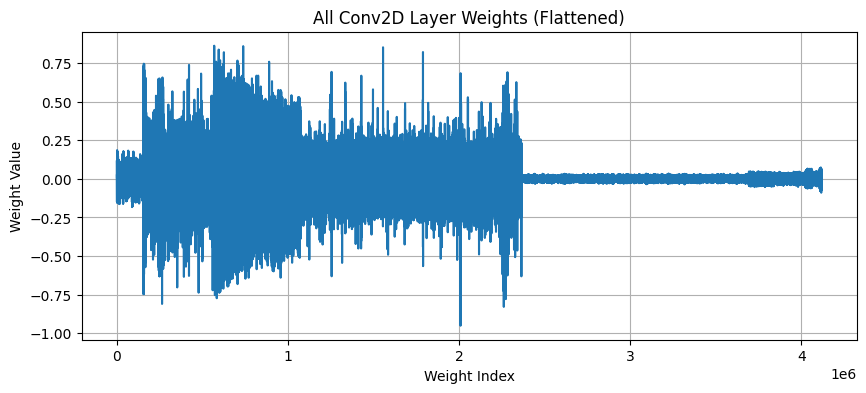

In [38]:
parameters_conv[0].size()

all_weights = []

# Collect flattened weights from all Conv2D layers
for p in parameters_conv:
    weights = p.detach().cpu().flatten()
    all_weights.append(weights)

# Concatenate into one long tensor
all_weights_flat = torch.cat(all_weights)

# Plot in a single chart
plt.figure(figsize=(10, 4))
plt.plot(all_weights_flat.numpy())
plt.title("All Conv2D Layer Weights (Flattened)")
plt.xlabel("Weight Index")
plt.ylabel("Weight Value")
plt.grid(True)
plt.show()

d:\dev\mit\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


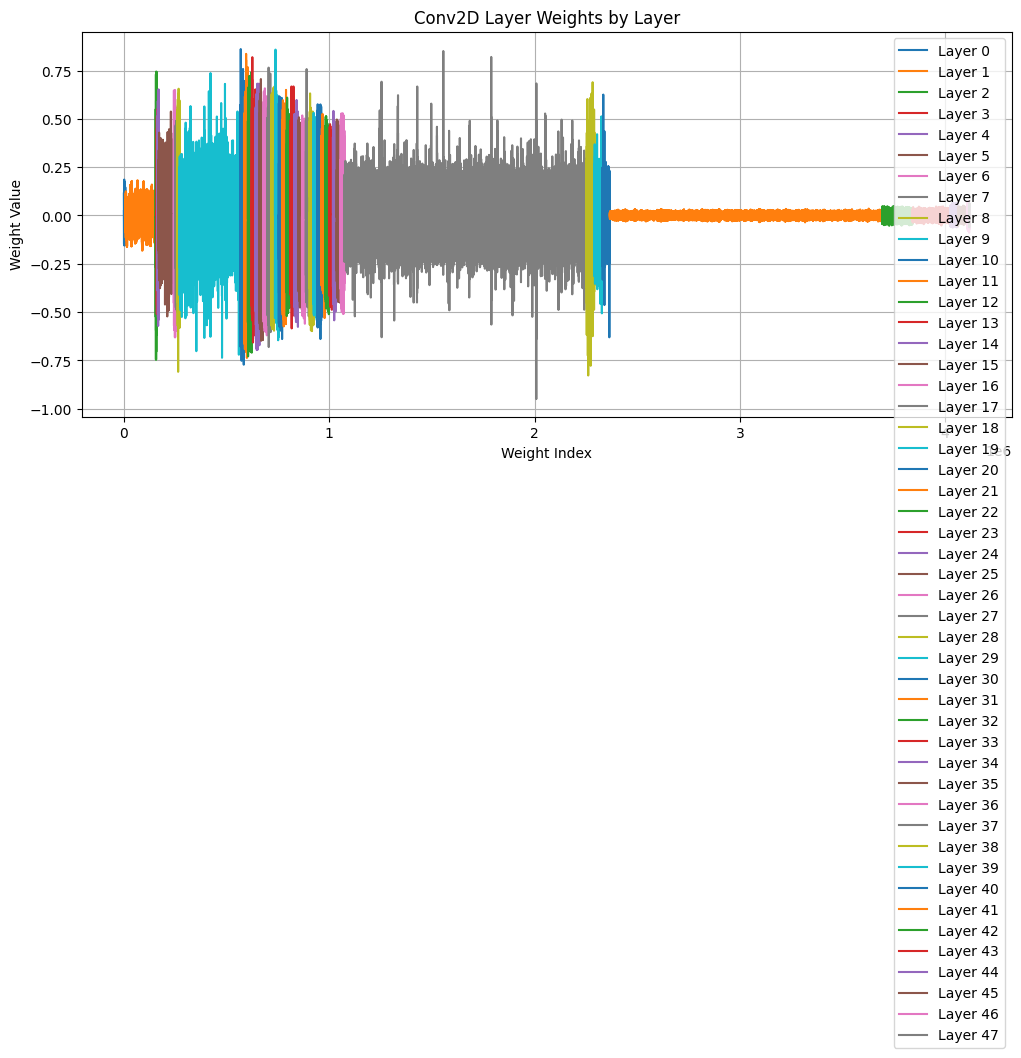

In [39]:
plt.figure(figsize=(12, 5))

offset = 0
for i, p in enumerate(parameters_conv):
    weights = p.detach().cpu().flatten()
    x = torch.arange(offset, offset + len(weights))
    plt.plot(x.numpy(), weights.numpy(), label=f"Layer {i}")
    offset += len(weights)

plt.title("Conv2D Layer Weights by Layer")
plt.xlabel("Weight Index")
plt.ylabel("Weight Value")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
optimizer = torch.optim.AdamW([
    {'params': model.backbone.stages_0.parameters(), 'lr': 1e-5},      # Pretrained backbone
    {'params': model.backbone.stages_1.parameters(), 'lr': 1e-3} # New classification head
])

|Typical Learning Rate Assignments in Deep Networks|||
|--|--|--|
|- Model Part|	Learning Rate Size|	Reason / Explanation|
|- Early Encoder| Layers	Small LR|	These layers extract generic, low-level features (edges, textures). Usually pretrained and well-optimized, so small LR avoids destroying learned features (stability).|
|- Later Encoder Layers	|Medium LR|	More task-specific features start to emerge. Sometimes a slightly higher LR than early layers helps adapt them better to the new task.|
|- Decoder / Head Layers|	Large LR	|Often randomly initialized or task-specific layers (classification head, segmentation decoder). Need to learn quickly from scratch, so use higher LR.|
|- Newly Added Layers	|Large LR	|Same as decoder — new layers typically require higher LR to learn fast.|
|- Normalization Layers (BatchNorm, LayerNorm)|Often small or zero LR|	Usually, you freeze or apply small LR to avoid disturbing learned statistics or parameters.|

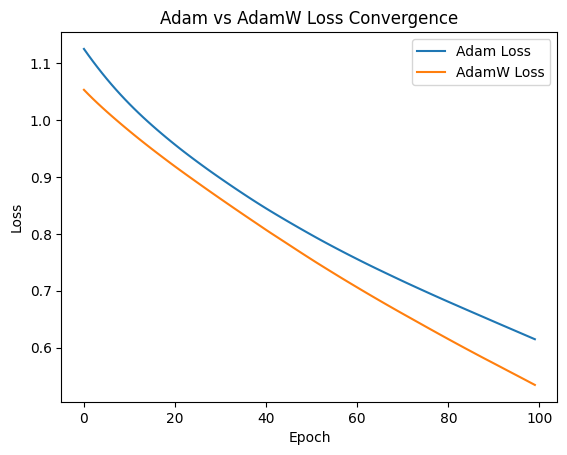

In [ ]:
#################################
#################################
#################################
### COMPARING ADAM and ADAMW loss
#################################
#################################
#################################


import torch
import torch.nn as nn
import torch.optim as optim

# Sample neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(10, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Instantiate model and loss
model = SimpleNet()
loss_fn = nn.MSELoss()
data = torch.randn(64, 10)
target = torch.randn(64, 1)

# Adam Optimizer
adam_optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
adam_loss = []
for _ in range(100):
    adam_optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    loss.backward()
    adam_optimizer.step()
    adam_loss.append(loss.item())

# AdamW Optimizer
model = SimpleNet()  # Reset model weights
adamw_optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
adamw_loss = []
for _ in range(100):
    adamw_optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    loss.backward()
    adamw_optimizer.step()
    adamw_loss.append(loss.item())


import matplotlib.pyplot as plt

plt.plot(adam_loss, label="Adam Loss")
plt.plot(adamw_loss, label="AdamW Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Adam vs AdamW Loss Convergence")
plt.show()


When to Choose Adam: You can use Adam for quick prototyping or simpler tasks where regularization is not crucial. It may converge faster initially but can suffer from poor generalization due to interference from weight decay.
When to Choose AdamW: In case you have larger models or when training on complex, high-dimensional data, it’s better to choose AdamW, because the decoupled weight decay helps achieve better generalization and stable convergence.